In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import shutil
import os
import zipfile

if not os.path.exists('/content/images_64x64'):
  shutil.copy(
      '/content/drive/MyDrive/Final Project/LDM/data/images_64x64.zip',
      '/content/'
  )
  with zipfile.ZipFile("/content/images_64x64.zip","r") as zip_ref:
    zip_ref.extractall("/content/images_64x64/")

In [ ]:
!pip install -q -U einops datasets tqdm
!pip install matplotlib==3.1.3

import math
from inspect import isfunction
from functools import partial
from PIL import Image
import requests

%matplotlib inline
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from einops import rearrange

import torch
from torch import nn, einsum
import torch.nn.functional as F

import glob
import numpy as np

     |████████████████████████████████| 41 kB 508 kB/s 
     |████████████████████████████████| 451 kB 11.6 MB/s 
     |████████████████████████████████| 132 kB 79.4 MB/s 
     |████████████████████████████████| 182 kB 73.2 MB/s 
     |████████████████████████████████| 212 kB 69.7 MB/s 
     |████████████████████████████████| 127 kB 74.9 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 13.1 MB 8.2 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2


In [ ]:
def exists(x):
    return x is not None

def default(val, d):
    if exists(val):
        return val
    return d() if isfunction(d) else d

class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, *args, **kwargs):
        return self.fn(x, *args, **kwargs) + x

def Upsample(dim):
    return nn.ConvTranspose2d(dim, dim, 4, 2, 1)

def Downsample(dim):
    return nn.Conv2d(dim, dim, 4, 2, 1)

In [ ]:
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

In [ ]:
#@title Cond Blocks

class CondConvNextBlock(nn.Module):
    """https://arxiv.org/abs/2201.03545"""

    def __init__(self, dim, dim_out, time_emb_dim=None, cond_dim=None, mult=2, norm=True):
        super().__init__()

        if time_emb_dim is not None:
          self.time_mlp = nn.Sequential(
              nn.GELU(), 
              nn.Linear(time_emb_dim, dim)
          )
        else:
          self.time_mlp = None

        if cond_dim is not None:
          self.cond_mlp = nn.Sequential(
              nn.GELU(), 
              nn.Linear(cond_dim, dim)
          )
        else:
          self.cond_mlp = None

        self.ds_conv = nn.Conv2d(dim, dim, 7, padding=3, groups=dim)

        self.net = nn.Sequential(
            nn.GroupNorm(1, dim) if norm else nn.Identity(),
            nn.Conv2d(dim, dim_out * mult, 3, padding=1),
            nn.GELU(),
            nn.GroupNorm(1, dim_out * mult),
            nn.Conv2d(dim_out * mult, dim_out, 3, padding=1),
        )

        self.res_conv = nn.Conv2d(dim, dim_out, 1) if dim != dim_out else nn.Identity()

    def forward(self, x, t, c):
        h = self.ds_conv(x)

        if self.time_mlp is not None and t is not None:
          t = self.time_mlp(t)
          h = h + rearrange(t, "b c -> b c 1 1")

        if self.cond_mlp is not None and c is not None:
          c = self.cond_mlp(c)
          h = h + rearrange(c, "b c -> b c 1 1")

        h = self.net(h)
        return h + self.res_conv(x)

In [ ]:
#@title attention
class Attention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head**-0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)
        self.to_out = nn.Conv2d(hidden_dim, dim, 1)

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(
            lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv
        )
        q = q * self.scale

        sim = einsum("b h d i, b h d j -> b h i j", q, k)
        sim = sim - sim.amax(dim=-1, keepdim=True).detach()
        attn = sim.softmax(dim=-1)

        out = einsum("b h i j, b h d j -> b h i d", attn, v)
        out = rearrange(out, "b h (x y) d -> b (h d) x y", x=h, y=w)
        return self.to_out(out)

class LinearAttention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head**-0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)

        self.to_out = nn.Sequential(nn.Conv2d(hidden_dim, dim, 1), 
                                    nn.GroupNorm(1, dim))

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(
            lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv
        )

        q = q.softmax(dim=-2)
        k = k.softmax(dim=-1)

        q = q * self.scale
        context = torch.einsum("b h d n, b h e n -> b h d e", k, v)

        out = torch.einsum("b h d e, b h d n -> b h e n", context, q)
        out = rearrange(out, "b h c (x y) -> b (h c) x y", h=self.heads, x=h, y=w)
        return self.to_out(out)

In [ ]:
#@title norm
class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.fn = fn
        self.norm = nn.GroupNorm(1, dim)

    def forward(self, x):
        x = self.norm(x)
        return self.fn(x)

In [ ]:
#@title Conditional Unet
class CondUnet(nn.Module):
    def __init__(
        self,
        dim,
        cond_dim,
        init_dim=None,
        out_dim=None,
        dim_mults=(1, 2, 4, 8),
        channels=3,
        with_time_emb=True,
        resnet_block_groups=8,
        use_convnext=True,
        convnext_mult=2,
    ):
        super().__init__()

        # determine dimensions
        self.channels = channels

        init_dim = default(init_dim, dim // 3 * 2)
        self.init_conv = nn.Conv2d(channels, init_dim, 7, padding=3)

        dims = [init_dim, *map(lambda m: dim * m, dim_mults)]
        in_out = list(zip(dims[:-1], dims[1:]))

        block_klass = partial(CondConvNextBlock, mult=convnext_mult)

        # time embeddings
        time_dim = dim * 4
        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbeddings(dim),
            nn.Linear(dim, time_dim),
            nn.GELU(),
            nn.Linear(time_dim, time_dim),
        )

        # conditional embeddings
        self.cond_mlp = nn.Sequential(
            nn.Linear(cond_dim, cond_dim),
            nn.GELU(),
            nn.Linear(cond_dim, cond_dim),
        )

        # layers
        self.downs = nn.ModuleList([])
        self.ups = nn.ModuleList([])
        num_resolutions = len(in_out)

        for ind, (dim_in, dim_out) in enumerate(in_out):
            is_last = ind >= (num_resolutions - 1)

            self.downs.append(
                nn.ModuleList(
                    [
                        block_klass(dim_in, dim_out, time_emb_dim=time_dim, cond_dim=cond_dim),
                        block_klass(dim_out, dim_out, time_emb_dim=time_dim, cond_dim=cond_dim),
                        Residual(PreNorm(dim_out, LinearAttention(dim_out))),
                        Downsample(dim_out) if not is_last else nn.Identity(),
                    ]
                )
            )

        mid_dim = dims[-1]
        self.mid_block1 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim, cond_dim=cond_dim)
        self.mid_attn = Residual(PreNorm(mid_dim, Attention(mid_dim)))
        self.mid_block2 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim, cond_dim=cond_dim)

        for ind, (dim_in, dim_out) in enumerate(reversed(in_out[1:])):
            is_last = ind >= (num_resolutions - 1)

            self.ups.append(
                nn.ModuleList(
                    [
                        block_klass(dim_out * 2, dim_in, time_emb_dim=time_dim, cond_dim=cond_dim),
                        block_klass(dim_in, dim_in, time_emb_dim=time_dim, cond_dim=cond_dim),
                        Residual(PreNorm(dim_in, LinearAttention(dim_in))),
                        Upsample(dim_in) if not is_last else nn.Identity(),
                    ]
                )
            )

        out_dim = default(out_dim, channels)

        # self.final_conv = nn.Sequential(
        #     block_klass(dim, dim, None, None), 
        #     nn.Conv2d(dim, out_dim, 1)
        # )

        self.final_block = block_klass(dim, dim, None, None)
        self.final_conv = nn.Conv2d(dim, out_dim, 1)

    def forward(self, x, time, cond):
        x = self.init_conv(x)

        t = self.time_mlp(time) if exists(self.time_mlp) else None

        if cond is None or not exists(self.cond_mlp):
          c = None
        else:
          c = self.cond_mlp(cond) if exists(self.cond_mlp) else None

        h = []

        # downsample
        for block1, block2, attn, downsample in self.downs:
            x = block1(x, t, c)
            x = block2(x, t, c)
            x = attn(x)
            h.append(x)
            x = downsample(x)

        # bottleneck
        x = self.mid_block1(x, t, c)
        x = self.mid_attn(x)
        x = self.mid_block2(x, t, c)

        # upsample
        for block1, block2, attn, upsample in self.ups:
            x = torch.cat((x, h.pop()), dim=1)
            x = block1(x, t, c)
            x = block2(x, t, c)
            x = attn(x)
            x = upsample(x)

        x = self.final_block(x, t, c)
        x = self.final_conv(x)
        return x

In [ ]:
#@title Schedulers
def cosine_beta_schedule(timesteps, s=0.008):
    """
    cosine schedule as proposed in https://arxiv.org/abs/2102.09672
    """
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps)
    alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * torch.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0.0001, 0.9999)

def linear_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start, beta_end, timesteps)

def quadratic_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start**0.5, beta_end**0.5, timesteps) ** 2

def sigmoid_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    betas = torch.linspace(-6, 6, timesteps)
    return torch.sigmoid(betas) * (beta_end - beta_start) + beta_start

In [ ]:
timesteps = 200

# define beta schedule
betas = linear_beta_schedule(timesteps=timesteps)

# define alphas 
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)

# calculations for diffusion q(x_t | x_{t-1}) and others
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)

# calculations for posterior q(x_{t-1} | x_t, x_0)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

def extract(a, t, x_shape):
    batch_size = t.shape[0]
    out = a.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

In [ ]:
# forward diffusion
def q_sample(x_start, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x_start)

    sqrt_alphas_cumprod_t = extract(sqrt_alphas_cumprod, t, x_start.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(
        sqrt_one_minus_alphas_cumprod, t, x_start.shape
    )

    return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise

In [ ]:
def get_noisy_image(x_start, t):
  # add noise
  x_noisy = q_sample(x_start, t=t)

  # turn back into PIL image
  noisy_image = reverse_transform(x_noisy.squeeze())

  return noisy_image

In [ ]:
import matplotlib.pyplot as plt

# use seed for reproducability
torch.manual_seed(0)

# source: https://pytorch.org/vision/stable/auto_examples/plot_transforms.html#sphx-glr-auto-examples-plot-transforms-py
def plot(imgs, with_orig=False, row_title=None, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0]) + with_orig
    fig, axs = plt.subplots(figsize=(200,200), nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        row = [image] + row if with_orig else row
        for col_idx, img in enumerate(row):
            ax = axs[row_idx, col_idx]
            ax.imshow(np.asarray(img), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    if with_orig:
        axs[0, 0].set(title='Original image')
        axs[0, 0].title.set_size(8)
    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])

    plt.tight_layout()

In [ ]:
def p_losses(denoise_model, x_start, t, c, noise=None, loss_type="l1"):
    if noise is None:
        noise = torch.randn_like(x_start)

    x_noisy = q_sample(x_start=x_start, t=t, noise=noise)
    predicted_noise = denoise_model(x_noisy, t, c)

    if loss_type == 'l1':
        loss = F.l1_loss(noise, predicted_noise)
    elif loss_type == 'l2':
        loss = F.mse_loss(noise, predicted_noise)
    elif loss_type == "huber":
        loss = F.smooth_l1_loss(noise, predicted_noise)
    else:
        raise NotImplementedError()

    return loss

In [ ]:
from torchvision.transforms import Compose, ToTensor, Lambda, ToPILImage, CenterCrop, Resize

image_size = 128
image_transform = Compose([
    ToTensor(), # turn into Numpy array of shape HWC, divide by 255
    Lambda(lambda t: (t * 2) - 1),
])

reverse_transform = Compose([
     Lambda(lambda t: (t + 1) / 2),
     Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
     Lambda(lambda t: t * 255.),
     Lambda(lambda t: t.numpy().astype(np.uint8)),
     ToPILImage(),
])

In [ ]:
%%time
files = glob.glob('/content/images_64x64/images_64x64/*.JPEG')

images = []
for file in files:
  image = Image.open(file)
  image = np.array(image)

  if image.shape == (64, 64, 3):
    images.append(image)
  
train_images = np.array(images)
train_images = train_images/255.0
train_images = (train_images*2)-1
train_images = train_images.astype(np.float32)
print(train_images.min(), train_images.max())

-1.0 1.0
CPU times: user 11.9 s, sys: 7.41 s, total: 19.3 s
Wall time: 19.8 s


In [ ]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class ImageNet_Dataset(Dataset):
  def __init__(self, images):
    images = rearrange(images, 'b h w c -> b c h w')
    self.images = images

  def __len__(self):
    return len(self.images)
  
  def __getitem__(self, idx):
    return {'image': self.images[idx]}

class FMRI_Dataset(Dataset):
  def __init__(self, images, fmri):
    assert len(images) == len(fmri)

    images = rearrange(images, 'b h w c -> b c h w')
    self.image = images

    self.fmri = fmri

  def __len__(self):
    return len(self.image)

  def __getitem__(self, idx):
    return {'image': self.image[idx], 'fmri': self.fmri[idx]}

In [ ]:
image_size = 64
channels = 3
batch_size = 128

imagenet_dataset = ImageNet_Dataset(train_images)
imagenet_dataloader = DataLoader(imagenet_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
batch = next(iter(imagenet_dataloader))
print(batch.keys())

dict_keys(['image'])


In [ ]:
#@title sampling
@torch.no_grad()
def p_sample(model, x, t, c, t_index):
    betas_t = extract(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = extract(sqrt_recip_alphas, t, x.shape)
    
    # Equation 11 in the paper
    # Use our model (noise predictor) to predict the mean
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t, c) / sqrt_one_minus_alphas_cumprod_t
    )

    if t_index == 0:
        return model_mean
    else:
        posterior_variance_t = extract(posterior_variance, t, x.shape)
        noise = torch.randn_like(x)
        # Algorithm 2 line 4:
        return model_mean + torch.sqrt(posterior_variance_t) * noise 

# Algorithm 2 but save all images:
@torch.no_grad()
def p_sample_loop(model, cond, shape):
    device = next(model.parameters()).device

    b = shape[0]
    # start from pure noise (for each example in the batch)
    img = torch.randn(shape, device=device)
    imgs = []
    
    for i in tqdm(reversed(range(0, timesteps)), desc='sampling loop time step', total=timesteps):
        t = torch.full((b,), i, device=device, dtype=torch.long)
        img = p_sample(model, img, t, cond, i)
        imgs.append(img.cpu().numpy())
    return np.array(imgs)

@torch.no_grad()
def sample_from_model(model, cond, image_size, batch_size=16, channels=3):
    return p_sample_loop(model, cond, shape=(batch_size, channels, image_size, image_size))

In [ ]:
#@title prog bar
from math import floor

class Progress_Bar():
  def __init__(self, width, bar="#", space=" "):
      self.width = width
      self.bar = bar
      self.space = space

  def __call__(self, progress, end_string=''):
    bars = self.bar * int(floor(progress * self.width))
    blanks = self.space * (self.width - len(bars))

    end = "\n" if progress == 1.0 else ""

    print(f'\033[K\r[{bars}{blanks}] {end_string}', end=end)

In [ ]:
#@title idk
from pathlib import Path

def num_to_groups(num, divisor):
    groups = num // divisor
    remainder = num % divisor
    arr = [divisor] * groups
    if remainder > 0:
        arr.append(remainder)
    return arr

results_folder = Path("./results")
results_folder.mkdir(exist_ok = True)
save_and_sample_every = 1000

In [ ]:
#@title Model
from torch.optim import Adam
device = "cuda" if torch.cuda.is_available() else "cpu"

model = CondUnet(
    image_size,
    512,
    dim_mults=(1, 2, 4,)
)
model.to(device)

starting_epoch = 0

In [ ]:
loss_tracker = []

In [ ]:
from torch.optim import Adam
device = "cuda" if torch.cuda.is_available() else "cpu"

checkpoint_name = 'unc_64_10epochs_1670707059.tar'
prev_model = torch.load(f'/content/drive/MyDrive/Final Project/LDM/{checkpoint_name}')

model = CondUnet(
    image_size,
    512,
    dim_mults=(1, 2, 4,)
)
model.to(device)

model.load_state_dict(prev_model['model_state_dict'])

optimizer = Adam(model.parameters(), lr=1e-3)
optimizer.load_state_dict(prev_model['optimizer_state_dict'])

loss_tracker = prev_model['loss']

In [ ]:
#update learning rate
lr = 1e-4

osd = optimizer.state_dict()
optimizer = Adam(model.parameters(), lr=lr)
optimizer.load_state_dict(osd)

In [ ]:
#@title original training
# %%time
# from torchvision.utils import save_image

# epochs = 5

# progress_bar = Progress_Bar(50, bar="▓", space="░")
# num_batches = len(dataloader)

# for epoch in range(epochs):

#     print(f'Epoch: {epoch}')

#     for step, batch in enumerate(dataloader):
#       optimizer.zero_grad()

#       batch_size = batch["pixel_values"].shape[0]
#       batch = batch["pixel_values"].to(device)

#       # Algorithm 1 line 3: sample t uniformally for every example in the batch
#       t = torch.randint(0, timesteps, (batch_size,), device=device).long()

#       loss = p_losses(model, batch, t, loss_type="huber")
      
#       progress_bar((step/num_batches), f'Loss: {loss.item():.05f}')


#       loss.backward()
#       optimizer.step()

#       # save generated images
#       if step != 0 and step % save_and_sample_every == 0:
#         milestone = step // save_and_sample_every
#         batches = num_to_groups(4, batch_size)
#         all_images_list = list(map(lambda n: sample(model, batch_size=n, channels=channels), batches))
#         all_images = torch.cat(all_images_list, dim=0)
#         all_images = (all_images + 1) * 0.5
#         save_image(all_images, str(results_folder / f'sample-{milestone}.png'), nrow = 6)

In [ ]:
num_epochs = 1

In [ ]:
#@title Train!
%%time
from torchvision.utils import save_image
dataloader = imagenet_dataloader

progress_bar = Progress_Bar(50, bar="▓", space="░")
num_batches = len(dataloader)

for epoch in range(len(loss_tracker), len(loss_tracker)+num_epochs):

    losses = []
    print(f'Epoch: {epoch}')

    for step, batch in enumerate(dataloader):
      optimizer.zero_grad()

      batch_size = batch["image"].shape[0]
      images = batch["image"].to(device)
      # cond = batch["cond"].to(device)
      cond = None

      # Algorithm 1 line 3: sample t uniformally for every example in the batch
      t = torch.randint(0, timesteps, (batch_size,), device=device).long()

      loss = p_losses(model, images, t, cond, loss_type="l2")
      
      progress_bar((step/(num_batches-1)), f'Loss: {loss.item():.05f}')
      losses.append(loss.item())

      loss.backward()
      optimizer.step()

      # # save generated images
      # if step != 0 and step % save_and_sample_every == 0:
      #   milestone = step // save_and_sample_every
      #   batches = num_to_groups(4, batch_size)
      #   all_images_list = list(map(lambda n: sample(model, batch_size=n, channels=channels), batches))
      #   all_images = torch.cat(all_images_list, dim=0)
      #   all_images = (all_images + 1) * 0.5
      #   save_image(all_images, str(results_folder / f'sample-{milestone}.png'), nrow = 6)
    
    avg_loss = np.average(np.array(losses))
    loss_tracker.append(avg_loss)
    print(f'Average Loss = {avg_loss:.05f}')

Epoch: 10
[▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓░░░░░░░░░░░░░░░░░░░░░░] Loss: 0.13190

KeyboardInterrupt: ignored

In [ ]:
import time
model_name = f'unc_64_10epochs_{int(time.time())}'

torch.save({
    'ending_epoch': len(loss_tracker)-1,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': loss_tracker,
}, f'/content/drive/MyDrive/Final Project/LDM/{model_name}.tar')

In [ ]:
with torch.no_grad():
    torch.cuda.empty_cache()

[0.6982680708169937, 0.29331842381155715, 0.2274668135522109, 0.19732346673900225, 0.17893287602741764, 0.166592529430142, 0.15866189502741931, 0.15131510319715402, 0.1444863450871605, 0.13902282577781183]


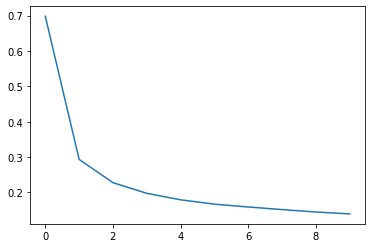

In [ ]:
print(loss_tracker)
x = list(range(len(loss_tracker)))

plt.plot(x, loss_tracker)

## Sampling (inference)

To sample from the model, we can just use our sample function defined above:


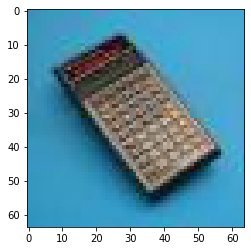

In [ ]:
sample_index = 2
sample_image = train_images[sample_index]/2.0 + 0.5
plt.imshow(sample_image)

In [ ]:
samples = sample_from_model(model, None, image_size=64, batch_size=10, channels=3)

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

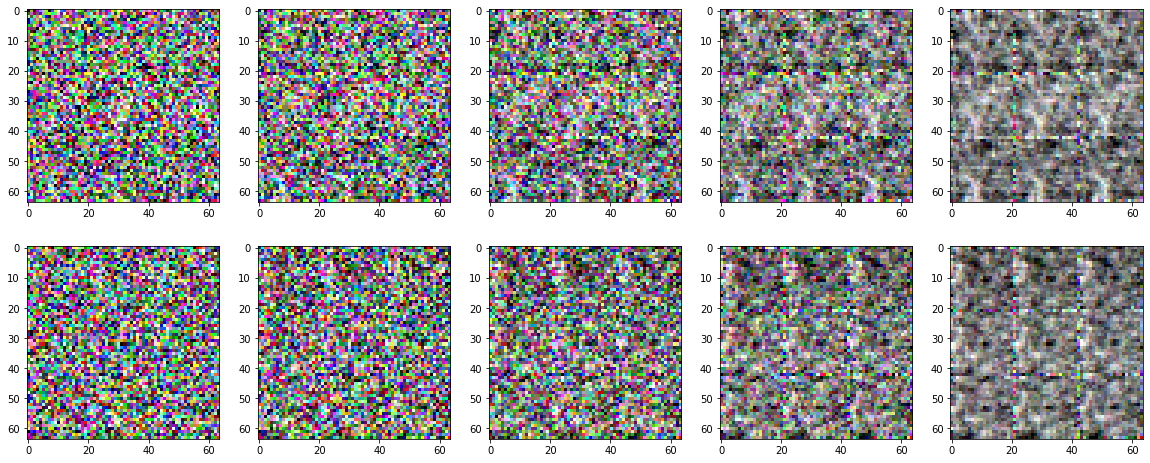

In [ ]:
rows = 2
cols = 5
fig, ax = plt.subplots(nrows = rows, ncols = cols)
fig.set_size_inches(20, 4*rows)

for r in range(rows):
  for c in range(cols):
    sample = samples[int((c+1)/cols*200)-1][r].reshape(64, 64,3)
    sample = sample/2.0 + 0.5
    sample = np.where(sample > 1.0, 1.0, sample)
    sample = np.where(sample < 0.0, 0.0, sample)
    ax[r][c].imshow(sample)

plt.show()

In [ ]:

random_index = 3

frames = []
for i in range(timesteps):
    sample = samples[i][random_index].reshape(64, 64, 3)
    sample = sample/2.0 + 0.5
    sample = np.where(sample > 1.0, 1.0, sample)
    sample = np.where(sample < 0.0, 0.0, sample)
    sample = (sample*255).astype(np.uint8)
    
    frame = Image.fromarray(sample, 'RGB')

    frames.append(frame)

frames[0].save('diffusion.gif', save_all=True, append_images=frames[1:], duration=10, loop=0)